In [14]:
import os
import tqdm
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
import xgboost
import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import joblib
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, LinearLR, MultiStepLR

## Data analysis and preprocessing

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)


def create_dataset(path):
    for i, elem in enumerate(['df_'+str(a) for a in range(0, 12)]):
        elem = read_parquet_dataset_from_local(path, i, 1)
        if i==0:
            df = elem.copy()
        else:
            df = pd.concat([df, elem], ignore_index=True, axis=0)
        del elem
    return df

In [4]:
pd.options.display.max_columns = None

In [5]:
path = 'train_data/'
df = create_dataset(path)
df.head()

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\bogho\AppData\Local\Temp\ipykernel_572\1433847333.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,0,1,1,1,1,16,2,17,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0


In [15]:
df.shape

(26162717, 61)

In [18]:
for elem in df.columns:
    print('------------------------------')
    print(df[elem].value_counts().head(10))
    print(df[elem].nunique())

------------------------------
id
2891734    58
1782755    55
1658519    54
62963      51
508303     51
318999     50
755726     50
517425     49
2479204    49
2160706    48
Name: count, dtype: int64
3000000
------------------------------
rn
1     3000000
2     2779455
3     2550810
4     2320731
5     2094188
6     1876509
7     1668536
8     1473997
9     1294408
10    1130303
Name: count, dtype: int64
58
------------------------------
pre_since_opened
13    1645938
0     1561873
6     1522882
10    1409770
8     1406244
18    1388400
14    1315095
9     1312790
7     1307521
1     1300842
Name: count, dtype: int64
20
------------------------------
pre_since_confirmed
9     4909419
6     1948337
4     1514861
17    1503451
3     1435553
14    1410504
10    1361991
13    1313856
7     1291490
1     1245131
Name: count, dtype: int64
18
------------------------------
pre_pterm
4     4456185
14    2336504
2     1532229
17    1520418
1     1483207
16    1460983
11    1430459
9     1428200

enc_paym_24
4    21966247
1     3919903
2      251452
3       25115
Name: count, dtype: int64
4
------------------------------
enc_loans_account_holder_type
1    25807322
3      213021
4      117422
6       20625
5        2232
2        2031
0          64
Name: count, dtype: int64
7
------------------------------
enc_loans_credit_status
3    17561773
2     8276203
4      201958
5       68431
1       48568
6        3803
0        1981
Name: count, dtype: int64
7
------------------------------
enc_loans_credit_type
4    14774986
3     7736233
5     1050346
1      880196
0      756480
2      617386
7      310217
6       36873
Name: count, dtype: int64
8
------------------------------
enc_loans_account_cur
1    26100882
2       53102
0        8550
3         183
Name: count, dtype: int64
4
------------------------------
pclose_flag
0    22259294
1     3903423
Name: count, dtype: int64
2
------------------------------
fclose_flag
0    20172292
1     5990425
Name: count, dtype: int64
2


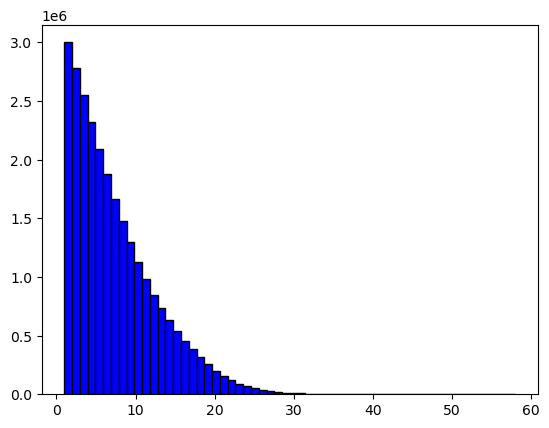

In [32]:
#распределение кредитный продуктов по клиентам
plt.hist(df['rn'], color = 'blue', edgecolor = 'black', bins = int(df['rn'].nunique()));

In [9]:
cat_columns = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 
        'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur']

In [10]:
df.isna().sum()
#пропусков нет

id                         0
rn                         0
pre_since_opened           0
pre_since_confirmed        0
pre_pterm                  0
                          ..
enc_loans_credit_status    0
enc_loans_credit_type      0
enc_loans_account_cur      0
pclose_flag                0
fclose_flag                0
Length: 61, dtype: int64

In [33]:
targets = pd.read_csv('train_target.csv')
targets

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [12]:
#так как часть данных бинаризована имеет смысл провести кодирование с последующей группировкой + данные по длине совпадут с таргетом

In [35]:
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore', dtype='int8')
df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
df.drop(columns=cat_columns, inplace=True)

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
C:\Users\bogho\AppData\Local\Temp\ipykernel_572\3302740645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [37]:
df.shape

(26162717, 362)

In [38]:
#новый признак
df_1 = df.iloc[:, :2].copy().groupby(['id']).max()
df_1.columns = ['max_rn']

In [39]:
df = df.groupby(['id']).sum()
df.merge(df_1, how='left', on='id').drop(columns='rn')
df.loc[:, 'target'] = targets.loc[:, 'flag']

C:\Users\bogho\AppData\Local\Temp\ipykernel_572\2228575633.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'target'] = targets.loc[:, 'flag']


In [40]:
int_64_cols  = df.select_dtypes('int64').columns
df[int_64_cols] = df[int_64_cols].astype('int8')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 2999999
Columns: 362 entries, rn to target
dtypes: int8(362)
memory usage: 1.0 GB


In [42]:
df['target'].value_counts()

target
0    2893558
1     106442
Name: count, dtype: int64

In [43]:
df['target'].value_counts()[1]/df['target'].value_counts()[0]

0.03678585326438938

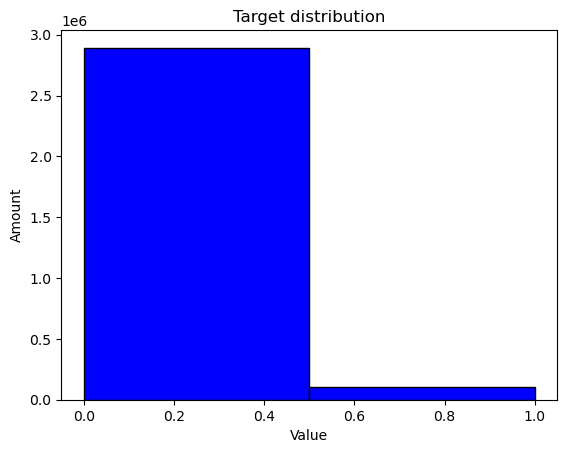

In [48]:
plt.hist(df['target'], color = 'blue', edgecolor = 'black', bins = int(df['target'].nunique()))
plt.title('Target distribution')
plt.xlabel('Value')
plt.ylabel('Amount');

## Modeling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

### Random Forest

In [15]:
%%time
rf = RandomForestClassifier(n_estimators=15,
                           max_depth=9,
                           min_samples_leaf=8).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7300298634541145
test:  0.7195067107844934
CPU times: total: 59.6 s
Wall time: 59.8 s


In [19]:
%%time
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 40)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',  2, 15)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_train, y_train, cv=2, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

[I 2024-09-11 14:39:03,955] A new study created in memory with name: no-name-1330a484-cba5-4e15-9316-bdf9d38710e2
[I 2024-09-11 14:41:02,636] Trial 0 finished with value: 0.7258250291061215 and parameters: {'n_estimators': 27, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7258250291061215.
[I 2024-09-11 14:42:05,072] Trial 1 finished with value: 0.7146212460243859 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7258250291061215.
[I 2024-09-11 14:43:19,629] Trial 2 finished with value: 0.7181767691075756 and parameters: {'n_estimators': 23, 'max_depth': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7258250291061215.
[I 2024-09-11 14:45:05,072] Trial 3 finished with value: 0.7251672187765128 and parameters: {'n_estimators': 26, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7258250291061215.
[I 2024-09-11 14:45:54,389] Trial 4 finished with value: 0.704203318113463 and p

[I 2024-09-11 15:57:15,722] Trial 40 finished with value: 0.7224512214481229 and parameters: {'n_estimators': 22, 'max_depth': 9, 'min_samples_leaf': 14}. Best is trial 11 with value: 0.7278116250344678.
[I 2024-09-11 15:59:31,003] Trial 41 finished with value: 0.7264532969159494 and parameters: {'n_estimators': 35, 'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 11 with value: 0.7278116250344678.
[I 2024-09-11 16:01:42,392] Trial 42 finished with value: 0.7268488308842687 and parameters: {'n_estimators': 34, 'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 11 with value: 0.7278116250344678.
[I 2024-09-11 16:03:59,140] Trial 43 finished with value: 0.7247377266025172 and parameters: {'n_estimators': 36, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.7278116250344678.
[I 2024-09-11 16:06:02,908] Trial 44 finished with value: 0.7273937710233973 and parameters: {'n_estimators': 32, 'max_depth': 10, 'min_samples_leaf': 13}. Best is trial 11 with valu

CPU times: total: 1h 35min 56s
Wall time: 1h 36min 23s


In [20]:
best_params

{'n_estimators': 33, 'max_depth': 10, 'min_samples_leaf': 14}

In [25]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7435445833965082
test:  0.7284031662748849
CPU times: total: 2min 16s
Wall time: 2min 16s


In [35]:
imp_df = pd.DataFrame({'features': X_train.columns.tolist(), 'imp': rf.feature_importances_.tolist()})
new_columns = imp_df.loc[imp_df['imp']!=0, 'features']

In [37]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train[new_columns], y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train[new_columns])[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test[new_columns])[:,1]))

train:  0.7423180453915181
test:  0.7264555741531732
CPU times: total: 2min 10s
Wall time: 2min 10s


In [38]:
%%time
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 100)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',  2, 31)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_train[new_columns], y_train, cv=2, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

best_params = study.best_params
best_score = study.best_value

[I 2024-09-11 16:47:06,948] A new study created in memory with name: no-name-5d7a2a73-131c-4275-a6c3-3d68af496585
[I 2024-09-11 16:48:25,993] Trial 0 finished with value: 0.7024097943796903 and parameters: {'n_estimators': 38, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7024097943796903.
[I 2024-09-11 16:50:34,582] Trial 1 finished with value: 0.7056682868792233 and parameters: {'n_estimators': 68, 'max_depth': 5, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.7056682868792233.
[I 2024-09-11 16:52:10,890] Trial 2 finished with value: 0.7248859378181118 and parameters: {'n_estimators': 30, 'max_depth': 9, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.7248859378181118.
[I 2024-09-11 16:54:50,076] Trial 3 finished with value: 0.72257673315996 and parameters: {'n_estimators': 57, 'max_depth': 8, 'min_samples_leaf': 16}. Best is trial 2 with value: 0.7248859378181118.
[I 2024-09-11 16:56:24,497] Trial 4 finished with value: 0.7097894894844551 and pa

[I 2024-09-11 19:54:49,982] Trial 40 finished with value: 0.7286112442209363 and parameters: {'n_estimators': 54, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 31 with value: 0.7329188686234716.
[I 2024-09-11 20:01:42,638] Trial 41 finished with value: 0.7324203790072682 and parameters: {'n_estimators': 99, 'max_depth': 11, 'min_samples_leaf': 23}. Best is trial 31 with value: 0.7329188686234716.
[I 2024-09-11 20:08:46,003] Trial 42 finished with value: 0.7323359559181566 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 21}. Best is trial 31 with value: 0.7329188686234716.
[I 2024-09-11 20:14:55,563] Trial 43 finished with value: 0.7325484517532441 and parameters: {'n_estimators': 90, 'max_depth': 11, 'min_samples_leaf': 25}. Best is trial 31 with value: 0.7329188686234716.
[I 2024-09-11 20:21:08,831] Trial 44 finished with value: 0.7324385320712982 and parameters: {'n_estimators': 95, 'max_depth': 11, 'min_samples_leaf': 27}. Best is trial 31 with v

CPU times: total: 5h 52min 11s
Wall time: 6h 28min 29s


In [41]:
%%time
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                           max_depth=best_params['max_depth'],
                           min_samples_leaf=best_params['min_samples_leaf']).fit(X_train, y_train)

print('train: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print('test: ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

train:  0.7542475988164754
test:  0.7324634480010748
CPU times: total: 7min 51s
Wall time: 7min 53s


### XGBoost

In [5]:
%%time
model = xgboost.XGBClassifier(
    n_estimators=350,
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.05,
    eval_metric='auc',
    early_stopping_rounds=10
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

[0]	validation_0-auc:0.71161	validation_1-auc:0.70195
[10]	validation_0-auc:0.73547	validation_1-auc:0.72135
[20]	validation_0-auc:0.74660	validation_1-auc:0.72781
[30]	validation_0-auc:0.76035	validation_1-auc:0.73324
[40]	validation_0-auc:0.77237	validation_1-auc:0.73815
[50]	validation_0-auc:0.78398	validation_1-auc:0.74251
[60]	validation_0-auc:0.79339	validation_1-auc:0.74554
[70]	validation_0-auc:0.80181	validation_1-auc:0.74823
[80]	validation_0-auc:0.80941	validation_1-auc:0.75005
[90]	validation_0-auc:0.81582	validation_1-auc:0.75161
[100]	validation_0-auc:0.82144	validation_1-auc:0.75294
[110]	validation_0-auc:0.82651	validation_1-auc:0.75386
[120]	validation_0-auc:0.83110	validation_1-auc:0.75472
[130]	validation_0-auc:0.83484	validation_1-auc:0.75529
[140]	validation_0-auc:0.83869	validation_1-auc:0.75573
[150]	validation_0-auc:0.84231	validation_1-auc:0.75611
[160]	validation_0-auc:0.84549	validation_1-auc:0.75644
[170]	validation_0-auc:0.84832	validation_1-auc:0.75679
[18

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
imp_df = pd.DataFrame({'features': X_train.columns.tolist(), 'imp': model.feature_importances_.tolist()})
new_columns = imp_df.loc[imp_df['imp']!=0, 'features']

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 150, 300, step=10)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.01, 1)
    colsample_bynode = trial.suggest_float('colsample_bynode', 0.01, 1)
    

    model = xgboost.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                                  subsample=subsample, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel,
                                  colsample_bynode=colsample_bynode, objective='binary:logistic', 
                                  eval_metric='auc', early_stopping_rounds=10).fit(X_train[new_columns], y_train, 
                                  eval_set=[(X_train[new_columns], y_train), (X_test[new_columns], y_test)], verbose=10)
    metric = model.evals_result()['validation_1']['auc'][-1]
    
    return metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_score = study.best_value

[I 2024-09-13 22:29:55,672] A new study created in memory with name: no-name-0b88ef18-7c64-48a9-a5e2-0e927d9c1465


[0]	validation_0-auc:0.69741	validation_1-auc:0.68559
[10]	validation_0-auc:0.76287	validation_1-auc:0.73285
[20]	validation_0-auc:0.78629	validation_1-auc:0.74156
[30]	validation_0-auc:0.80561	validation_1-auc:0.74610
[40]	validation_0-auc:0.81854	validation_1-auc:0.74818
[50]	validation_0-auc:0.82935	validation_1-auc:0.74913
[60]	validation_0-auc:0.83774	validation_1-auc:0.74974
[70]	validation_0-auc:0.84544	validation_1-auc:0.74987
[75]	validation_0-auc:0.84864	validation_1-auc:0.74991


[I 2024-09-13 22:36:59,482] Trial 0 finished with value: 0.749911128942446 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.161511876567625, 'subsample': 0.8244521823185775, 'colsample_bytree': 0.5015345900285135, 'colsample_bylevel': 0.8370947456605976, 'colsample_bynode': 0.9172872713445984}. Best is trial 0 with value: 0.749911128942446.


[0]	validation_0-auc:0.69360	validation_1-auc:0.68299
[10]	validation_0-auc:0.74967	validation_1-auc:0.72870
[20]	validation_0-auc:0.75692	validation_1-auc:0.73338
[30]	validation_0-auc:0.76555	validation_1-auc:0.73696
[40]	validation_0-auc:0.77280	validation_1-auc:0.73914
[50]	validation_0-auc:0.77985	validation_1-auc:0.74175
[60]	validation_0-auc:0.78668	validation_1-auc:0.74395
[70]	validation_0-auc:0.79295	validation_1-auc:0.74579
[80]	validation_0-auc:0.79892	validation_1-auc:0.74764
[90]	validation_0-auc:0.80414	validation_1-auc:0.74925
[100]	validation_0-auc:0.80946	validation_1-auc:0.75062
[110]	validation_0-auc:0.81499	validation_1-auc:0.75189
[120]	validation_0-auc:0.81877	validation_1-auc:0.75293
[130]	validation_0-auc:0.82217	validation_1-auc:0.75350
[140]	validation_0-auc:0.82526	validation_1-auc:0.75423
[150]	validation_0-auc:0.82909	validation_1-auc:0.75491
[159]	validation_0-auc:0.83212	validation_1-auc:0.75544


[I 2024-09-13 22:50:55,369] Trial 1 finished with value: 0.7554409473833255 and parameters: {'n_estimators': 160, 'max_depth': 10, 'learning_rate': 0.046878702823603756, 'subsample': 0.9267854122866171, 'colsample_bytree': 0.7107403313497744, 'colsample_bylevel': 0.846544027693068, 'colsample_bynode': 0.45921348458229183}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.66996	validation_1-auc:0.66385
[10]	validation_0-auc:0.72450	validation_1-auc:0.71488
[20]	validation_0-auc:0.73494	validation_1-auc:0.72408
[30]	validation_0-auc:0.73865	validation_1-auc:0.72659
[40]	validation_0-auc:0.74025	validation_1-auc:0.72767
[50]	validation_0-auc:0.74182	validation_1-auc:0.72870
[60]	validation_0-auc:0.74309	validation_1-auc:0.72971
[70]	validation_0-auc:0.74414	validation_1-auc:0.73046
[80]	validation_0-auc:0.74512	validation_1-auc:0.73115
[90]	validation_0-auc:0.74618	validation_1-auc:0.73181
[100]	validation_0-auc:0.74749	validation_1-auc:0.73268
[110]	validation_0-auc:0.74865	validation_1-auc:0.73339
[120]	validation_0-auc:0.74957	validation_1-auc:0.73368
[130]	validation_0-auc:0.75074	validation_1-auc:0.73429
[140]	validation_0-auc:0.75213	validation_1-auc:0.73526
[150]	validation_0-auc:0.75279	validation_1-auc:0.73551
[160]	validation_0-auc:0.75411	validation_1-auc:0.73638
[170]	validation_0-auc:0.75493	validation_1-auc:0.73681
[18

[I 2024-09-13 23:07:51,413] Trial 2 finished with value: 0.7383663207764164 and parameters: {'n_estimators': 190, 'max_depth': 9, 'learning_rate': 0.013067613328025893, 'subsample': 0.5092608335872872, 'colsample_bytree': 0.3803120244084715, 'colsample_bylevel': 0.6064094599015112, 'colsample_bynode': 0.21803840867137184}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.68870	validation_1-auc:0.67687
[10]	validation_0-auc:0.75133	validation_1-auc:0.72563
[20]	validation_0-auc:0.76785	validation_1-auc:0.73389
[30]	validation_0-auc:0.78207	validation_1-auc:0.73923
[40]	validation_0-auc:0.79375	validation_1-auc:0.74312
[50]	validation_0-auc:0.80391	validation_1-auc:0.74555
[60]	validation_0-auc:0.81109	validation_1-auc:0.74740
[70]	validation_0-auc:0.81792	validation_1-auc:0.74887
[80]	validation_0-auc:0.82362	validation_1-auc:0.75003
[90]	validation_0-auc:0.82859	validation_1-auc:0.75086
[100]	validation_0-auc:0.83309	validation_1-auc:0.75169
[110]	validation_0-auc:0.83701	validation_1-auc:0.75214
[120]	validation_0-auc:0.84095	validation_1-auc:0.75238
[130]	validation_0-auc:0.84447	validation_1-auc:0.75253
[140]	validation_0-auc:0.84721	validation_1-auc:0.75271
[150]	validation_0-auc:0.84946	validation_1-auc:0.75268
[160]	validation_0-auc:0.85314	validation_1-auc:0.75275
[170]	validation_0-auc:0.85578	validation_1-auc:0.75289
[18

[I 2024-09-13 23:25:09,809] Trial 3 finished with value: 0.7527734735202671 and parameters: {'n_estimators': 220, 'max_depth': 11, 'learning_rate': 0.09420033417226022, 'subsample': 0.601098228514666, 'colsample_bytree': 0.4201858265709551, 'colsample_bylevel': 0.6193211547251812, 'colsample_bynode': 0.23774715457784554}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.63286	validation_1-auc:0.63060
[10]	validation_0-auc:0.70063	validation_1-auc:0.69928
[20]	validation_0-auc:0.71606	validation_1-auc:0.71332
[30]	validation_0-auc:0.72509	validation_1-auc:0.72197
[40]	validation_0-auc:0.72955	validation_1-auc:0.72577
[50]	validation_0-auc:0.73308	validation_1-auc:0.72878
[60]	validation_0-auc:0.73606	validation_1-auc:0.73130
[70]	validation_0-auc:0.73867	validation_1-auc:0.73367
[80]	validation_0-auc:0.74129	validation_1-auc:0.73601
[90]	validation_0-auc:0.74341	validation_1-auc:0.73782
[100]	validation_0-auc:0.74518	validation_1-auc:0.73925
[110]	validation_0-auc:0.74684	validation_1-auc:0.74059
[120]	validation_0-auc:0.74804	validation_1-auc:0.74156
[130]	validation_0-auc:0.74925	validation_1-auc:0.74257
[140]	validation_0-auc:0.75049	validation_1-auc:0.74350
[150]	validation_0-auc:0.75153	validation_1-auc:0.74423
[160]	validation_0-auc:0.75255	validation_1-auc:0.74505
[170]	validation_0-auc:0.75349	validation_1-auc:0.74578
[18

[I 2024-09-13 23:40:59,636] Trial 4 finished with value: 0.7470636251202062 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.06718629030332496, 'subsample': 0.5787635966997519, 'colsample_bytree': 0.8225846376399627, 'colsample_bylevel': 0.10348178613983762, 'colsample_bynode': 0.6581477718013764}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.63716	validation_1-auc:0.63338
[10]	validation_0-auc:0.73108	validation_1-auc:0.71562
[20]	validation_0-auc:0.75733	validation_1-auc:0.73330
[30]	validation_0-auc:0.76818	validation_1-auc:0.73845
[40]	validation_0-auc:0.77757	validation_1-auc:0.74222
[50]	validation_0-auc:0.78519	validation_1-auc:0.74394
[60]	validation_0-auc:0.79081	validation_1-auc:0.74515
[70]	validation_0-auc:0.79637	validation_1-auc:0.74565
[80]	validation_0-auc:0.80108	validation_1-auc:0.74617
[90]	validation_0-auc:0.80493	validation_1-auc:0.74667
[100]	validation_0-auc:0.80820	validation_1-auc:0.74674
[107]	validation_0-auc:0.81083	validation_1-auc:0.74666


[I 2024-09-13 23:50:49,057] Trial 5 finished with value: 0.7466607261972841 and parameters: {'n_estimators': 210, 'max_depth': 9, 'learning_rate': 0.2435175028152844, 'subsample': 0.8794098756440447, 'colsample_bytree': 0.2732135458112331, 'colsample_bylevel': 0.46516252217531684, 'colsample_bynode': 0.18843038735724102}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.64919	validation_1-auc:0.64565
[10]	validation_0-auc:0.72086	validation_1-auc:0.71625
[20]	validation_0-auc:0.73278	validation_1-auc:0.72598
[30]	validation_0-auc:0.74240	validation_1-auc:0.73358
[40]	validation_0-auc:0.74825	validation_1-auc:0.73779
[50]	validation_0-auc:0.75251	validation_1-auc:0.74057
[60]	validation_0-auc:0.75670	validation_1-auc:0.74313
[70]	validation_0-auc:0.75994	validation_1-auc:0.74489
[80]	validation_0-auc:0.76261	validation_1-auc:0.74634
[90]	validation_0-auc:0.76486	validation_1-auc:0.74729
[100]	validation_0-auc:0.76704	validation_1-auc:0.74805
[110]	validation_0-auc:0.76926	validation_1-auc:0.74891
[120]	validation_0-auc:0.77133	validation_1-auc:0.74961
[130]	validation_0-auc:0.77301	validation_1-auc:0.75016
[140]	validation_0-auc:0.77464	validation_1-auc:0.75052
[150]	validation_0-auc:0.77630	validation_1-auc:0.75091
[160]	validation_0-auc:0.77745	validation_1-auc:0.75137
[169]	validation_0-auc:0.77883	validation_1-auc:0.75170


[I 2024-09-14 00:05:49,343] Trial 6 finished with value: 0.751702767417999 and parameters: {'n_estimators': 170, 'max_depth': 7, 'learning_rate': 0.10095050004303552, 'subsample': 0.5032070357071157, 'colsample_bytree': 0.3870675411206709, 'colsample_bylevel': 0.1832787951997413, 'colsample_bynode': 0.8427943211422522}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.70027	validation_1-auc:0.68642
[10]	validation_0-auc:0.77927	validation_1-auc:0.73422
[20]	validation_0-auc:0.81304	validation_1-auc:0.74114
[30]	validation_0-auc:0.83179	validation_1-auc:0.74291
[40]	validation_0-auc:0.84381	validation_1-auc:0.74342
[46]	validation_0-auc:0.85092	validation_1-auc:0.74322


[I 2024-09-14 00:10:23,128] Trial 7 finished with value: 0.7433450834241371 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.21824388144235177, 'subsample': 0.6952138908553469, 'colsample_bytree': 0.5405704329713454, 'colsample_bylevel': 0.5963356327595103, 'colsample_bynode': 0.7160353242775659}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.69994	validation_1-auc:0.68695
[10]	validation_0-auc:0.74336	validation_1-auc:0.72605
[20]	validation_0-auc:0.74922	validation_1-auc:0.72976
[30]	validation_0-auc:0.75187	validation_1-auc:0.73098
[40]	validation_0-auc:0.75397	validation_1-auc:0.73214
[50]	validation_0-auc:0.75677	validation_1-auc:0.73339
[60]	validation_0-auc:0.76025	validation_1-auc:0.73484
[70]	validation_0-auc:0.76358	validation_1-auc:0.73618
[80]	validation_0-auc:0.76676	validation_1-auc:0.73724
[90]	validation_0-auc:0.77000	validation_1-auc:0.73821
[100]	validation_0-auc:0.77345	validation_1-auc:0.73926
[110]	validation_0-auc:0.77689	validation_1-auc:0.74029
[120]	validation_0-auc:0.78028	validation_1-auc:0.74156
[130]	validation_0-auc:0.78380	validation_1-auc:0.74262
[140]	validation_0-auc:0.78705	validation_1-auc:0.74373
[150]	validation_0-auc:0.78968	validation_1-auc:0.74455
[160]	validation_0-auc:0.79254	validation_1-auc:0.74545
[170]	validation_0-auc:0.79578	validation_1-auc:0.74638
[18

[I 2024-09-14 00:28:19,445] Trial 8 finished with value: 0.7486532773825357 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.019327839011844195, 'subsample': 0.8117759432052736, 'colsample_bytree': 0.712728504367715, 'colsample_bylevel': 0.6840642588902938, 'colsample_bynode': 0.9275178855885574}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.57745	validation_1-auc:0.57413
[10]	validation_0-auc:0.65544	validation_1-auc:0.64767
[20]	validation_0-auc:0.68236	validation_1-auc:0.67531
[30]	validation_0-auc:0.69521	validation_1-auc:0.68701
[40]	validation_0-auc:0.70276	validation_1-auc:0.69319
[50]	validation_0-auc:0.71119	validation_1-auc:0.70050
[60]	validation_0-auc:0.71815	validation_1-auc:0.70704
[70]	validation_0-auc:0.72217	validation_1-auc:0.71035
[80]	validation_0-auc:0.72754	validation_1-auc:0.71525
[90]	validation_0-auc:0.73154	validation_1-auc:0.71843
[100]	validation_0-auc:0.73407	validation_1-auc:0.72048
[110]	validation_0-auc:0.73620	validation_1-auc:0.72208
[120]	validation_0-auc:0.73790	validation_1-auc:0.72305
[130]	validation_0-auc:0.73949	validation_1-auc:0.72396
[140]	validation_0-auc:0.74111	validation_1-auc:0.72498
[150]	validation_0-auc:0.74373	validation_1-auc:0.72696
[160]	validation_0-auc:0.74463	validation_1-auc:0.72762
[170]	validation_0-auc:0.74630	validation_1-auc:0.72887
[17

[I 2024-09-14 00:43:52,642] Trial 9 finished with value: 0.7297092478598769 and parameters: {'n_estimators': 180, 'max_depth': 10, 'learning_rate': 0.10131514714060086, 'subsample': 0.7187977352286066, 'colsample_bytree': 0.07207256114305227, 'colsample_bylevel': 0.223829551864628, 'colsample_bynode': 0.33909394461262443}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.67140	validation_1-auc:0.66568
[10]	validation_0-auc:0.74228	validation_1-auc:0.73125
[20]	validation_0-auc:0.76150	validation_1-auc:0.74240
[30]	validation_0-auc:0.77211	validation_1-auc:0.74648
[40]	validation_0-auc:0.77919	validation_1-auc:0.74839
[50]	validation_0-auc:0.78504	validation_1-auc:0.74933
[60]	validation_0-auc:0.78931	validation_1-auc:0.74975
[70]	validation_0-auc:0.79310	validation_1-auc:0.74973
[75]	validation_0-auc:0.79540	validation_1-auc:0.74969


[I 2024-09-14 00:50:41,657] Trial 10 finished with value: 0.7496927655549788 and parameters: {'n_estimators': 270, 'max_depth': 7, 'learning_rate': 0.29753062810780206, 'subsample': 0.9782752859192283, 'colsample_bytree': 0.9632833688443286, 'colsample_bylevel': 0.9954376700999024, 'colsample_bynode': 0.46132630431942045}. Best is trial 1 with value: 0.7554409473833255.


[0]	validation_0-auc:0.66984	validation_1-auc:0.65442
[10]	validation_0-auc:0.75072	validation_1-auc:0.72521
[20]	validation_0-auc:0.76320	validation_1-auc:0.73187
[30]	validation_0-auc:0.77231	validation_1-auc:0.73569
[40]	validation_0-auc:0.77920	validation_1-auc:0.73810
[50]	validation_0-auc:0.78778	validation_1-auc:0.74162
[60]	validation_0-auc:0.79614	validation_1-auc:0.74423
[70]	validation_0-auc:0.80203	validation_1-auc:0.74628
[80]	validation_0-auc:0.80840	validation_1-auc:0.74792
[90]	validation_0-auc:0.81325	validation_1-auc:0.74929
[100]	validation_0-auc:0.81867	validation_1-auc:0.75067
[110]	validation_0-auc:0.82346	validation_1-auc:0.75174
[120]	validation_0-auc:0.82710	validation_1-auc:0.75241
[130]	validation_0-auc:0.83113	validation_1-auc:0.75296
[140]	validation_0-auc:0.83478	validation_1-auc:0.75350
[150]	validation_0-auc:0.83857	validation_1-auc:0.75403
[160]	validation_0-auc:0.84128	validation_1-auc:0.75450
[170]	validation_0-auc:0.84428	validation_1-auc:0.75483
[18

[I 2024-09-14 01:13:36,554] Trial 11 finished with value: 0.7558939908887452 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.06735579460360834, 'subsample': 0.9996402635396491, 'colsample_bytree': 0.7236008349889372, 'colsample_bylevel': 0.8190023295381147, 'colsample_bynode': 0.057800614822374946}. Best is trial 11 with value: 0.7558939908887452.


[0]	validation_0-auc:0.63773	validation_1-auc:0.63109
[10]	validation_0-auc:0.71971	validation_1-auc:0.70249
[20]	validation_0-auc:0.73152	validation_1-auc:0.71183
[30]	validation_0-auc:0.74117	validation_1-auc:0.71810
[40]	validation_0-auc:0.74893	validation_1-auc:0.72310
[50]	validation_0-auc:0.75485	validation_1-auc:0.72634
[60]	validation_0-auc:0.75985	validation_1-auc:0.72927
[70]	validation_0-auc:0.76518	validation_1-auc:0.73234
[80]	validation_0-auc:0.77065	validation_1-auc:0.73470
[90]	validation_0-auc:0.77542	validation_1-auc:0.73723
[100]	validation_0-auc:0.77877	validation_1-auc:0.73813
[110]	validation_0-auc:0.78229	validation_1-auc:0.73957
[120]	validation_0-auc:0.78544	validation_1-auc:0.74100
[130]	validation_0-auc:0.78790	validation_1-auc:0.74213
[140]	validation_0-auc:0.79044	validation_1-auc:0.74298
[150]	validation_0-auc:0.79265	validation_1-auc:0.74369
[160]	validation_0-auc:0.79530	validation_1-auc:0.74465
[170]	validation_0-auc:0.79716	validation_1-auc:0.74538
[18

[I 2024-09-14 01:36:54,130] Trial 12 finished with value: 0.7502280850653281 and parameters: {'n_estimators': 260, 'max_depth': 11, 'learning_rate': 0.05640185779446525, 'subsample': 0.9944909031712248, 'colsample_bytree': 0.6776236673090396, 'colsample_bylevel': 0.8827522623879193, 'colsample_bynode': 0.017688367745230582}. Best is trial 11 with value: 0.7558939908887452.


[0]	validation_0-auc:0.63267	validation_1-auc:0.63197
[10]	validation_0-auc:0.71383	validation_1-auc:0.70550
[20]	validation_0-auc:0.73264	validation_1-auc:0.72151
[30]	validation_0-auc:0.74440	validation_1-auc:0.72963
[40]	validation_0-auc:0.75240	validation_1-auc:0.73495
[50]	validation_0-auc:0.75700	validation_1-auc:0.73795
[60]	validation_0-auc:0.76197	validation_1-auc:0.74086
[70]	validation_0-auc:0.76632	validation_1-auc:0.74264
[80]	validation_0-auc:0.77015	validation_1-auc:0.74427
[90]	validation_0-auc:0.77310	validation_1-auc:0.74542
[100]	validation_0-auc:0.77632	validation_1-auc:0.74663
[110]	validation_0-auc:0.77885	validation_1-auc:0.74749
[120]	validation_0-auc:0.78114	validation_1-auc:0.74813
[130]	validation_0-auc:0.78335	validation_1-auc:0.74869
[140]	validation_0-auc:0.78525	validation_1-auc:0.74902
[150]	validation_0-auc:0.78709	validation_1-auc:0.74946
[160]	validation_0-auc:0.78883	validation_1-auc:0.74985
[170]	validation_0-auc:0.79057	validation_1-auc:0.74999
[18

[I 2024-09-14 02:01:46,877] Trial 13 finished with value: 0.7519365109733452 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.13302191064342322, 'subsample': 0.9172185080925574, 'colsample_bytree': 0.8890473214771155, 'colsample_bylevel': 0.8191845990140474, 'colsample_bynode': 0.025885989778272944}. Best is trial 11 with value: 0.7558939908887452.


[0]	validation_0-auc:0.67407	validation_1-auc:0.66483
[10]	validation_0-auc:0.74591	validation_1-auc:0.72899
[20]	validation_0-auc:0.76642	validation_1-auc:0.73911
[30]	validation_0-auc:0.78099	validation_1-auc:0.74484
[40]	validation_0-auc:0.79158	validation_1-auc:0.74773
[50]	validation_0-auc:0.79803	validation_1-auc:0.74940
[60]	validation_0-auc:0.80473	validation_1-auc:0.75046
[70]	validation_0-auc:0.81060	validation_1-auc:0.75134
[80]	validation_0-auc:0.81526	validation_1-auc:0.75191
[90]	validation_0-auc:0.81961	validation_1-auc:0.75223
[100]	validation_0-auc:0.82341	validation_1-auc:0.75234
[110]	validation_0-auc:0.82624	validation_1-auc:0.75237
[120]	validation_0-auc:0.82945	validation_1-auc:0.75245
[124]	validation_0-auc:0.83041	validation_1-auc:0.75237


[I 2024-09-14 02:12:56,637] Trial 14 finished with value: 0.7524526954073771 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.16239787908094344, 'subsample': 0.9192736087570007, 'colsample_bytree': 0.687626537858815, 'colsample_bylevel': 0.3293514152505958, 'colsample_bynode': 0.52113603660481}. Best is trial 11 with value: 0.7558939908887452.


[0]	validation_0-auc:0.70708	validation_1-auc:0.68798
[10]	validation_0-auc:0.76079	validation_1-auc:0.73204
[20]	validation_0-auc:0.76847	validation_1-auc:0.73500
[30]	validation_0-auc:0.77999	validation_1-auc:0.73886
[40]	validation_0-auc:0.78965	validation_1-auc:0.74164
[50]	validation_0-auc:0.79926	validation_1-auc:0.74397
[60]	validation_0-auc:0.80868	validation_1-auc:0.74638
[70]	validation_0-auc:0.81744	validation_1-auc:0.74834


In [9]:
%%time
model = xgboost.XGBClassifier(
    n_estimators=350,
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.047,
    subsample=0.9268,
    colsample_bytree=0.7107,
    colsample_bylevel=0.8465,
    colsample_bynode=0.4592,
    eval_metric='auc',
    early_stopping_rounds=10
)
model.fit(X_train[new_columns], y_train, eval_set=[(X_train[new_columns], y_train), (X_test[new_columns], y_test)], verbose=10)

[0]	validation_0-auc:0.68944	validation_1-auc:0.67947
[10]	validation_0-auc:0.74558	validation_1-auc:0.72982
[20]	validation_0-auc:0.75246	validation_1-auc:0.73360
[30]	validation_0-auc:0.76233	validation_1-auc:0.73783
[40]	validation_0-auc:0.77015	validation_1-auc:0.74088
[50]	validation_0-auc:0.77798	validation_1-auc:0.74360
[60]	validation_0-auc:0.78524	validation_1-auc:0.74582
[70]	validation_0-auc:0.79241	validation_1-auc:0.74801
[80]	validation_0-auc:0.79854	validation_1-auc:0.74990
[90]	validation_0-auc:0.80395	validation_1-auc:0.75143
[100]	validation_0-auc:0.80898	validation_1-auc:0.75267
[110]	validation_0-auc:0.81413	validation_1-auc:0.75389
[120]	validation_0-auc:0.81846	validation_1-auc:0.75464
[130]	validation_0-auc:0.82218	validation_1-auc:0.75545
[140]	validation_0-auc:0.82596	validation_1-auc:0.75622
[150]	validation_0-auc:0.82918	validation_1-auc:0.75681
[160]	validation_0-auc:0.83211	validation_1-auc:0.75712
[170]	validation_0-auc:0.83482	validation_1-auc:0.75751
[18

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8465, colsample_bynode=0.4592,
              colsample_bytree=0.7107, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.047, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Catboost

In [43]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)
boosting_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5136239	best: 0.5136239 (0)	total: 316ms	remaining: 1m 2s
20:	test: 0.7268109	best: 0.7268109 (20)	total: 11s	remaining: 1m 34s
40:	test: 0.7377880	best: 0.7377880 (40)	total: 21.7s	remaining: 1m 24s
60:	test: 0.7429433	best: 0.7429433 (60)	total: 32.5s	remaining: 1m 14s
80:	test: 0.7452983	best: 0.7452983 (80)	total: 42.8s	remaining: 1m 2s
100:	test: 0.7465679	best: 0.7465679 (100)	total: 52.6s	remaining: 51.6s
120:	test: 0.7474535	best: 0.7474535 (120)	total: 1m 2s	remaining: 40.7s
140:	test: 0.7483265	best: 0.7483265 (140)	total: 1m 11s	remaining: 30.1s
160:	test: 0.7487045	best: 0.7487069 (158)	total: 1m 21s	remaining: 19.7s
180:	test: 0.7490716	best: 0.7490716 (180)	total: 1m 30s	remaining: 9.5s
199:	test: 0.7493597	best: 0.7493773 (197)	total: 1m 40s	remaining: 0us

bestTest = 0.7493772559
bestIteration = 197

Shrink model to first 198 iterations.
train:  0.7578590434922184
test:  0.7493772559287459


### Grid

In [107]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)

params = {'depth': np.arange(4, 8, 1), 'learning_rate': np.arange(0.1, 0.5, 0.1), 'min_data_in_leaf': np.arange(3, 5, 1)}

boosting_model.grid_search(params, X_train, y_train, cv=3, search_by_train_test_split=True, calc_cv_statistics=True,
                           plot=True, refit=True, stratified=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5053388	best: 0.5053388 (0)	total: 177ms	remaining: 35.2s
20:	test: 0.6941101	best: 0.6941101 (20)	total: 4.86s	remaining: 41.4s
40:	test: 0.7078560	best: 0.7078560 (40)	total: 10.6s	remaining: 41.1s
60:	test: 0.7169596	best: 0.7169596 (60)	total: 16.5s	remaining: 37.5s
80:	test: 0.7235050	best: 0.7235050 (80)	total: 22.7s	remaining: 33.3s
100:	test: 0.7275101	best: 0.7275101 (100)	total: 29.3s	remaining: 28.7s
120:	test: 0.7309723	best: 0.7309723 (120)	total: 36.3s	remaining: 23.7s
140:	test: 0.7341186	best: 0.7341186 (140)	total: 43.2s	remaining: 18.1s
160:	test: 0.7363189	best: 0.7363189 (160)	total: 49.5s	remaining: 12s
180:	test: 0.7382495	best: 0.7382495 (180)	total: 56s	remaining: 5.88s
199:	test: 0.7393601	best: 0.7393601 (199)	total: 1m 2s	remaining: 0us

bestTest = 0.7393601424
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7393601	best: 0.7393601 

{'params': {'min_data_in_leaf': 3,
  'depth': 7,
  'learning_rate': 0.30000000000000004},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

20:	test: 0.6941101	best: 0.6941101 (20)	total: 5.75s	remaining: 49s
40:	test: 0.7078560	best: 0.7078560 (40)	total: 11.6s	remaining: 45.1s
60:	test: 0.7169596	best: 0.7169596 (60)	total: 17.3s	remaining: 39.5s
80:	test: 0.7235050	best: 0.7235050 (80)	total: 23.2s	remaining: 34s
100:	test: 0.7275101	best: 0.7275101 (100)	total: 29s	remaining: 28.4s
120:	test: 0.7309723	best: 0.7309723 (120)	total: 34.8s	remaining: 22.7s
140:	test: 0.7341186	best: 0.7341186 (140)	total: 41.1s	remaining: 17.2s
160:	test: 0.7363189	best: 0.7363189 (160)	total: 46.9s	remaining: 11.4s
180:	test: 0.7382495	best: 0.7382495 (180)	total: 53s	remaining: 5.56s
199:	test: 0.7393601	best: 0.7393601 (199)	total: 59s	remaining: 0us

bestTest = 0.7393601424
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 0.7393601	best: 0.7501471 (14)	total: 19m 40s	remaining: 17m 21s
0:	test: 0.5053388	best: 0.5053388 

0:	test: 0.5579289	best: 0.5579289 (0)	total: 237ms	remaining: 47.1s
20:	test: 0.7034370	best: 0.7034370 (20)	total: 6.84s	remaining: 58.3s
40:	test: 0.7186187	best: 0.7186187 (40)	total: 14.4s	remaining: 56s
60:	test: 0.7279600	best: 0.7279600 (60)	total: 22.1s	remaining: 50.5s
80:	test: 0.7331008	best: 0.7331008 (80)	total: 32.2s	remaining: 47.3s
100:	test: 0.7367479	best: 0.7367479 (100)	total: 40.7s	remaining: 39.9s
120:	test: 0.7396022	best: 0.7396022 (120)	total: 48.3s	remaining: 31.6s
140:	test: 0.7414634	best: 0.7414634 (140)	total: 56.3s	remaining: 23.6s
160:	test: 0.7429885	best: 0.7429885 (160)	total: 1m 3s	remaining: 15.5s
180:	test: 0.7442519	best: 0.7442519 (180)	total: 1m 11s	remaining: 7.5s
199:	test: 0.7451130	best: 0.7451130 (199)	total: 1m 18s	remaining: 0us

bestTest = 0.7451130219
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.7451130	best: 0.7501

0:	test: 0.5466240	best: 0.5466240 (0)	total: 308ms	remaining: 1m 1s
20:	test: 0.7280062	best: 0.7280062 (20)	total: 7.44s	remaining: 1m 3s
40:	test: 0.7372597	best: 0.7372597 (40)	total: 14.3s	remaining: 55.6s
60:	test: 0.7412573	best: 0.7412573 (60)	total: 20.9s	remaining: 47.5s
80:	test: 0.7433852	best: 0.7433852 (80)	total: 27.2s	remaining: 40s
100:	test: 0.7441864	best: 0.7441900 (99)	total: 33.5s	remaining: 32.8s
120:	test: 0.7447557	best: 0.7448117 (117)	total: 39.3s	remaining: 25.7s
140:	test: 0.7449382	best: 0.7450386 (133)	total: 45.3s	remaining: 18.9s
160:	test: 0.7453059	best: 0.7453059 (160)	total: 51.4s	remaining: 12.5s
180:	test: 0.7456439	best: 0.7456526 (176)	total: 57.5s	remaining: 6.03s
199:	test: 0.7458717	best: 0.7458717 (199)	total: 1m 2s	remaining: 0us

bestTest = 0.745871653
bestIteration = 199

Training on fold [1/3]
0:	test: 0.5030965	best: 0.5030965 (0)	total: 208ms	remaining: 41.4s
20:	test: 0.7269786	best: 0.7269786 (20)	total: 6.96s	remaining: 59.3s
40:	te

{'params': {'min_data_in_leaf': 3,
  'depth': 7,
  'learning_rate': 0.30000000000000004},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [135]:
best_params = boosting_model.get_all_params()
best_params

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 7,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model

In [5]:
boosting_model_2 = catboost.CatBoostClassifier(n_estimators=500, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42,
                                            depth=7, min_data_in_leaf=3)

boosting_model_2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model_2.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model_2.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5403323	best: 0.5403323 (0)	total: 449ms	remaining: 3m 44s
50:	test: 0.7406433	best: 0.7406433 (50)	total: 22.4s	remaining: 3m 17s
100:	test: 0.7458627	best: 0.7458772 (99)	total: 43.7s	remaining: 2m 52s
150:	test: 0.7473500	best: 0.7473639 (149)	total: 1m 4s	remaining: 2m 29s
200:	test: 0.7481973	best: 0.7482015 (199)	total: 1m 25s	remaining: 2m 7s
250:	test: 0.7485814	best: 0.7485814 (250)	total: 1m 47s	remaining: 1m 46s
300:	test: 0.7489793	best: 0.7489793 (300)	total: 2m 12s	remaining: 1m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7491580894
bestIteration = 308

Shrink model to first 309 iterations.
train:  0.7693149192237118
test:  0.7491580893562763


In [7]:
boosting_model_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,pre_util_3,8.154100
1,is_zero_loans530,7.547831
2,pre_loans_credit_limit_2,6.612090
3,pre_util_6,5.342999
4,enc_paym_22_3,4.650208
...,...,...
190,pre_loans3060_6,0.000000
191,pre_loans3060_9,0.000000
192,pre_loans6090_3,0.000000
193,pre_over2limit_18,0.000000


In [8]:
df_imp = pd.DataFrame(boosting_model_2.get_feature_importance(prettified=True))

In [9]:
len(df_imp.loc[df_imp['Importances']>0]['Feature Id'].tolist())

175

In [10]:
#убираю лишние фичи
df_imp = pd.DataFrame(boosting_model_2.get_feature_importance(prettified=True))
new_cols = df_imp.loc[df_imp['Importances']>0]['Feature Id'].tolist()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[new_cols], df['target'], stratify=df['target'], train_size=0.7)
X_train.shape

(2001418, 175)

In [12]:
boosting_model_2 = catboost.CatBoostClassifier(n_estimators=500, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42,
                                            depth=7, min_data_in_leaf=3)

boosting_model_2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model_2.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model_2.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5947286	best: 0.5947286 (0)	total: 345ms	remaining: 2m 52s
50:	test: 0.7426050	best: 0.7426050 (50)	total: 21s	remaining: 3m 4s
100:	test: 0.7477287	best: 0.7477287 (100)	total: 40.5s	remaining: 2m 39s
150:	test: 0.7498418	best: 0.7498418 (150)	total: 1m	remaining: 2m 18s
200:	test: 0.7507420	best: 0.7507819 (198)	total: 1m 19s	remaining: 1m 58s
250:	test: 0.7513661	best: 0.7513809 (249)	total: 1m 38s	remaining: 1m 37s
300:	test: 0.7518082	best: 0.7518316 (299)	total: 1m 57s	remaining: 1m 17s
350:	test: 0.7521967	best: 0.7522053 (349)	total: 2m 17s	remaining: 58.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7522874505
bestIteration = 357

Shrink model to first 358 iterations.
train:  0.7709935366016526
test:  0.7522874505188494


### Neural network

In [54]:
from tqdm.auto import tqdm

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], 
                                                    train_size=0.7, random_state=1)


X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False)

import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(361, 216, bias=True)
        self.fc2 = nn.Linear(216, 130, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(130, 78, bias=True)
        self.fc4 = nn.Linear(78, 39, bias=True)
        self.fc5 = nn.Linear(39, 1, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 15, X_train_t, y_train_t)



with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/15 [00:00<?, ?it/s]

curr_loss 0.1836996316200211
train:  0.7304729559196442
curr_loss 0.1411219557126363
train:  0.7460666199059471
curr_loss 0.13972157956588835
train:  0.7513843278067072
curr_loss 0.13877129334779012
train:  0.7570041933580814
curr_loss 0.13819176458886692
train:  0.7608164091577205
curr_loss 0.1378076552989937
train:  0.7627375672049768
curr_loss 0.1374118372797966
train:  0.7656595506650496
curr_loss 0.13705579155967348
train:  0.7690076909951372
curr_loss 0.13685141099350792
train:  0.7686768545830803
curr_loss 0.1365907577176889
train:  0.7713685655896559
curr_loss 0.13625181246371496
train:  0.774605643066052
curr_loss 0.13589044099762326
train:  0.7757127840407803
curr_loss 0.13552879478250232
train:  0.77796611830665
curr_loss 0.13521782124326343
train:  0.7794071986940345
curr_loss 0.13482717013075238
train:  0.7825171128905027
train:  0.7825188101411484
test:  0.7527168482160213


In [55]:
def plot_trainig(losses, metrics):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(losses, label="train_loss")
    #plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(metrics, label="train_roc-auc")
    plt.legend()

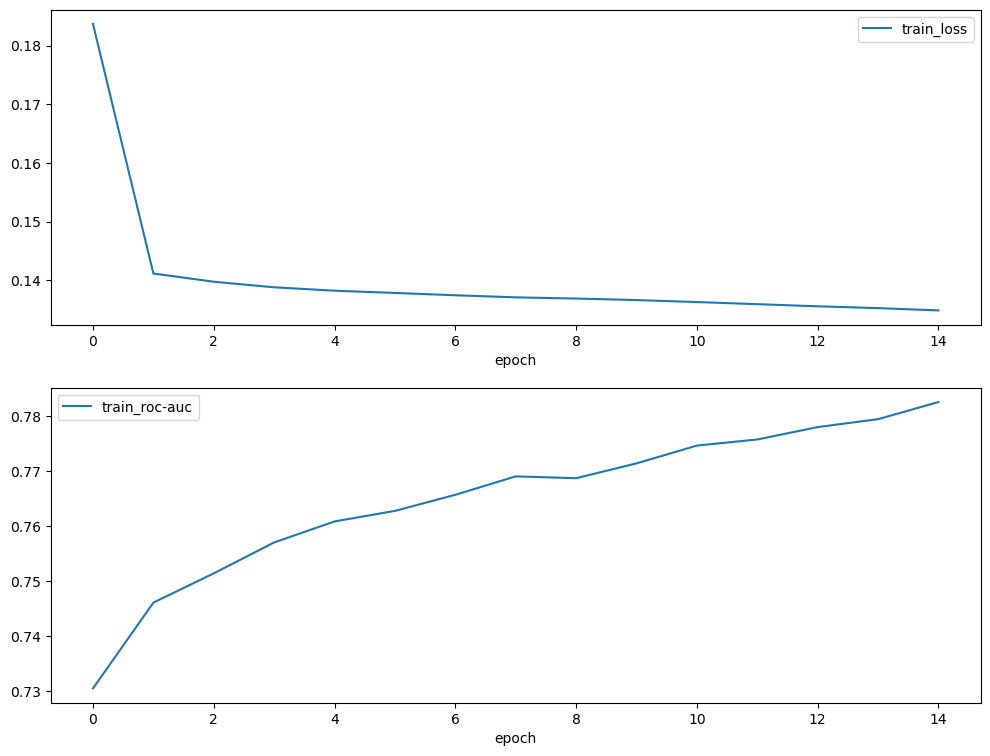

In [56]:
plot_trainig(losses, metrics)